In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow INFO and WARNING messages

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


E0000 00:00:1730627132.325218  201931 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730627132.331929  201931 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

In [4]:
import tensorflow as tf
import keras
import pandas as pd
import os
import keras_cv
import matplotlib.pyplot as plt

In [5]:
csv_file = 'ham10000_data/HAM10000_metadata.csv'
img_dir = 'ham10000_data/images'
file_ext = '.jpg'

df = pd.read_csv(csv_file)

image_paths = [
    os.path.join(img_dir, image_id + file_ext)
    for image_id in df['image_id']
]

print(f"Number of images: {len(image_paths)}")
print(f"First 5 image paths: {image_paths[:5]}")

classes = sorted(df['dx'].unique())
num_classes = len(classes)

print(f"Number of classes: {num_classes}")
print(f"Classes: {classes}")

labels = df['dx'].map(lambda x: classes.index(x)).values
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

print(f"Class to Index Mapping: {class_to_idx}")
print(f"Labels: {labels}")

Number of images: 10015
First 5 image paths: ['ham10000_data/images/ISIC_0027419.jpg', 'ham10000_data/images/ISIC_0025030.jpg', 'ham10000_data/images/ISIC_0026769.jpg', 'ham10000_data/images/ISIC_0025661.jpg', 'ham10000_data/images/ISIC_0031633.jpg']
Number of classes: 7
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Class to Index Mapping: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Labels: [2 2 2 ... 0 0 4]


In [6]:
def load_and_preprocess_image(image_id, label):
    # Load and preprocess the image
    image = tf.io.read_file(image_id)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))  # ResNet expects 224x224 images
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocessing for ResNet

    return image, label


In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

train_paths = []
train_labels = []
val_paths = []
val_labels = []

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, val_index in sss.split(image_paths, labels):
    train_paths = [image_paths[i] for i in train_index]
    train_labels = labels[train_index]
    val_paths = [image_paths[i] for i in val_index]
    val_labels = labels[val_index]

print(f"Training set size: {len(train_paths)}")
print(f"Validation set size: {len(val_paths)}")

train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

Training set size: 8012
Validation set size: 2003


I0000 00:00:1730627136.772791  201931 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:0b:00.0, compute capability: 6.0
I0000 00:00:1730627136.773435  201931 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 15513 MB memory:  -> device: 1, name: Tesla P100-PCIE-16GB, pci bus id: 0000:13:00.0, compute capability: 6.0


In [8]:
batch_size = 32

train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_dataset = train_dataset.cache()

val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.cache()


In [9]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
    keras.layers.RandomTranslation(0.1, 0.1),
])

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Compute class counts and class priors
class_counts = np.bincount(train_labels)
total_counts = np.sum(class_counts)
class_prior = class_counts / total_counts

# Clip class_prior to avoid log(0)
class_prior = np.clip(class_prior, 1e-7, 1.0)
output_bias = np.log(class_prior)

print(f"Class Counts: {class_counts}")
print(f"Class Prior: {class_prior}")
print(f"Output Bias: {output_bias}")

Class Counts: [ 262  411  879   92  890 5364  114]
Class Prior: [0.03270095 0.05129805 0.10971043 0.01148278 0.11108337 0.66949576
 0.01422866]
Output Bias: [-3.42035119 -2.97010248 -2.2099108  -4.46690712 -2.19747423 -0.40123045
 -4.25249725]


In [11]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    """
    Focal Loss for multi-class classification.

    Parameters:
    - gamma: Focusing parameter that adjusts the rate at which easy examples are down-weighted.
    - alpha: Balancing factor to balance the importance of different classes.

    Returns:
    - A loss function that can be used with multi-class classification models.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Convert the labels to one-hot encoding if necessary
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])

        # Clip predictions to prevent log(0)
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Compute cross entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Compute the focal loss weights
        loss_weight = alpha * K.pow(1 - y_pred, gamma)

        # Apply focal loss weights
        loss = loss_weight * cross_entropy

        # Sum over the last axis (the class axis)
        return K.sum(loss, axis=-1)

    return focal_loss_fixed


In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Reshape, Conv2D, Multiply, Add, Concatenate, Activation


class CBAM(Layer):
    def __init__(self, reduction_ratio=8, kernel_size=7):
        super(CBAM, self).__init__()
        self.reduction_ratio = reduction_ratio
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.channel_axis = -1
        self.channel = input_shape[self.channel_axis]

        self.shared_dense_one = Dense(self.channel // self.reduction_ratio,
                                      activation='relu',
                                      kernel_initializer='he_normal',
                                      use_bias=False)
        self.shared_dense_two = Dense(self.channel,
                                      activation='sigmoid',
                                      kernel_initializer='he_normal',
                                      use_bias=False)
        self.conv = Conv2D(1, kernel_size=self.kernel_size, padding='same', activation='sigmoid')

    def channel_attention(self, input_tensor):
        avg_pool = GlobalAveragePooling2D()(input_tensor)
        avg_pool = Reshape((1, 1, self.channel))(avg_pool)

        max_pool = GlobalMaxPooling2D()(input_tensor)
        max_pool = Reshape((1, 1, self.channel))(max_pool)

        avg_out = self.shared_dense_one(avg_pool)
        avg_out = self.shared_dense_two(avg_out)

        max_out = self.shared_dense_one(max_pool)
        max_out = self.shared_dense_two(max_out)

        combined = Add()([avg_out, max_out])
        scale = Activation('sigmoid')(combined)

        return Multiply()([input_tensor, scale])

    def spatial_attention(self, input_tensor):
        avg_pool = tf.reduce_mean(input_tensor, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(input_tensor, axis=-1, keepdims=True)
        concat = Concatenate(axis=-1)([avg_pool, max_pool])
        spatial_attention = self.conv(concat)
        return Multiply()([input_tensor, spatial_attention])

    def call(self, input_tensor):
        x = self.channel_attention(input_tensor)
        x = self.spatial_attention(x)

        x.trainable = True
        return x

In [13]:
import tensorflow as tf
from tensorflow import keras


def build_resnet50_with_cbam(hp):
    inputs = tf.keras.Input(shape=(224, 224, 3))

    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        pooling=None
    )

    # Freeze the base model
    base_model.trainable = False

    reduction_ratio = hp.Choice('reduction_ratio', values=[4, 8, 16, 32])
    kernel_size = hp.Choice('kernel_size', values=[3, 5, 7])

    cbam1 = CBAM(reduction_ratio=reduction_ratio, kernel_size=kernel_size)
    cbam2 = CBAM(reduction_ratio=reduction_ratio, kernel_size=kernel_size)
    cbam3 = CBAM(reduction_ratio=reduction_ratio, kernel_size=kernel_size)
    cbam4 = CBAM(reduction_ratio=reduction_ratio, kernel_size=kernel_size)

    cbam1.trainable = True
    cbam2.trainable = True
    cbam3.trainable = True
    cbam4.trainable = True

    # Applying CBAM layers to outputs of specific layers in the base model
    x = base_model.get_layer("conv2_block3_out").output
    x = cbam1(x)

    x = cbam2(base_model.get_layer("conv3_block4_out").output)
    x = cbam3(base_model.get_layer("conv4_block6_out").output)
    x = cbam4(base_model.get_layer("conv5_block3_out").output)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    dropout_rate = hp.Choice('dropout_rate', values=[0.2, 0.3, 0.5])
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    num_classes = 7
    output_bias = np.log(np.ones((num_classes,)) / num_classes)
    outputs = tf.keras.layers.Dense(
        num_classes,
        activation='softmax',
        bias_initializer=tf.keras.initializers.Constant(output_bias),
        kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2_regularization_output', values=[0.01, 0.001, 0.0001]))
    )(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    weight_decay = hp.Choice('weight_decay', values=[1e-2, 1e-3, 1e-4])
    optimizer_choice = hp.Choice('optimizer', values=['adamw', 'sgd'])

    if optimizer_choice == 'adamw':
        optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=hp.Choice('gamma', values=[0.5, 1.0, 2.0]), alpha=hp.Choice('alpha', values=[0.25, 0.5, 0.75])),
        metrics=['accuracy']
    )

    return model

In [14]:
from sklearn.utils import class_weight
import numpy as np


class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights_dict = dict(enumerate(class_weights))

In [15]:
import keras_tuner as kt

# Create a tuner
tuner = kt.Hyperband(
    build_resnet50_with_cbam,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='cbam_block_residual',
    project_name='hyperparameter_tuning'
)

# Perform the search
tuner.search(
  train_dataset,
  validation_data=val_dataset,
  epochs=20,
  class_weight=class_weights_dict
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps}")

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)


Trial 28 Complete [00h 05m 10s]
val_accuracy: 0.7009485960006714

Best val_accuracy So Far: 0.7763354778289795
Total elapsed time: 15h 22m 08s
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7e2763fa1660>


In [16]:
from keras.callbacks import ModelCheckpoint
import numpy as np


callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=12,
        min_delta=1e-4,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=4,
        min_lr=1e-7
    ),
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=500,
    callbacks=callbacks,
    class_weight=class_weights_dict,
)

Epoch 1/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 33s 91ms/step - accuracy: 0.3937 - loss: 1.0019 - val_accuracy: 0.6166 - val_loss: 0.5199 - learning_rate: 0.0010
Epoch 2/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.5829 - loss: 0.5653 - val_accuracy: 0.6640 - val_loss: 0.4253 - learning_rate: 0.0010
Epoch 3/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.6302 - loss: 0.4545 - val_accuracy: 0.6465 - val_loss: 0.4384 - learning_rate: 0.0010
Epoch 4/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.6361 - loss: 0.4315 - val_accuracy: 0.6565 - val_loss: 0.4224 - learning_rate: 0.0010
Epoch 5/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.6464 - loss: 0.3893 - val_accuracy: 0.6935 - val_loss: 0.3579 - learning_rate: 0.0010
Epoch 6/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.6813 - loss: 0.3487 - val_accuracy: 0.6760 - val_loss: 0.3931 - learning_rate: 0.0010
Epoch 7/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.6

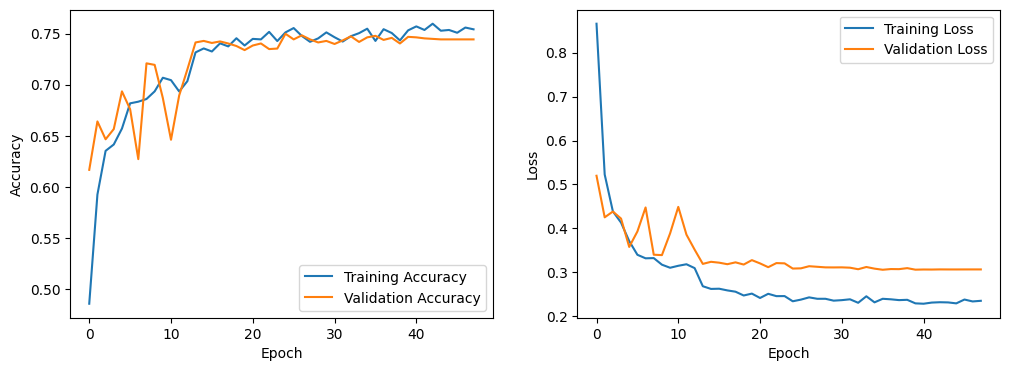

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

y_true = []
y_pred = []

def get_predictions(dataset):
    for images, labels in dataset:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))
    return np.array(y_true), np.array(y_pred)

# Get predictions for validation dataset
y_true, y_pred = get_predictions(val_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━

In [19]:
# Classification Report

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

       akiec       0.45      0.75      0.56        65
         bcc       0.54      0.66      0.59       103
         bkl       0.56      0.64      0.59       220
          df       0.30      0.61      0.41        23
         mel       0.44      0.64      0.52       223
          nv       0.96      0.79      0.87      1341
        vasc       0.70      0.75      0.72        28

    accuracy                           0.75      2003
   macro avg       0.56      0.69      0.61      2003
weighted avg       0.80      0.75      0.77      2003



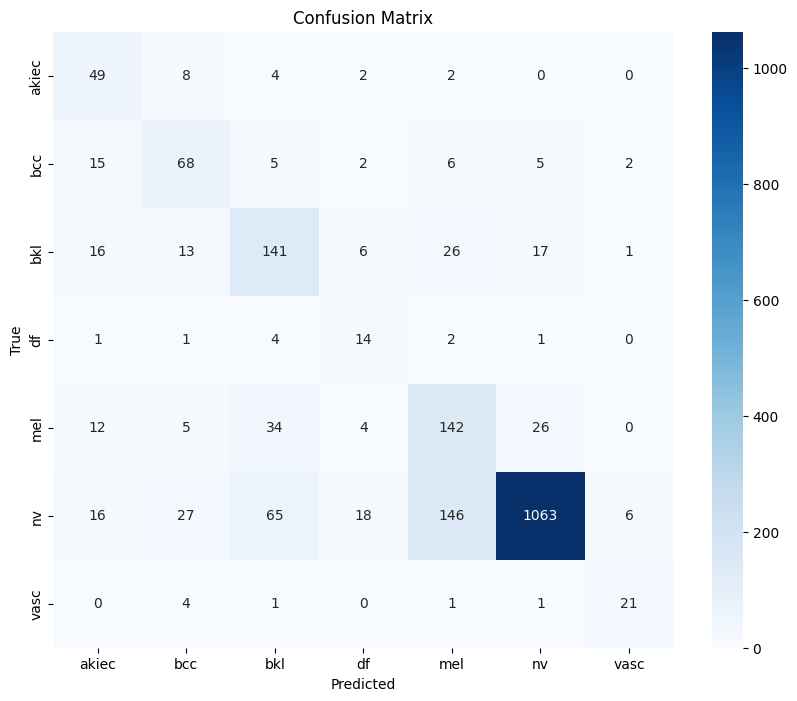

In [20]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

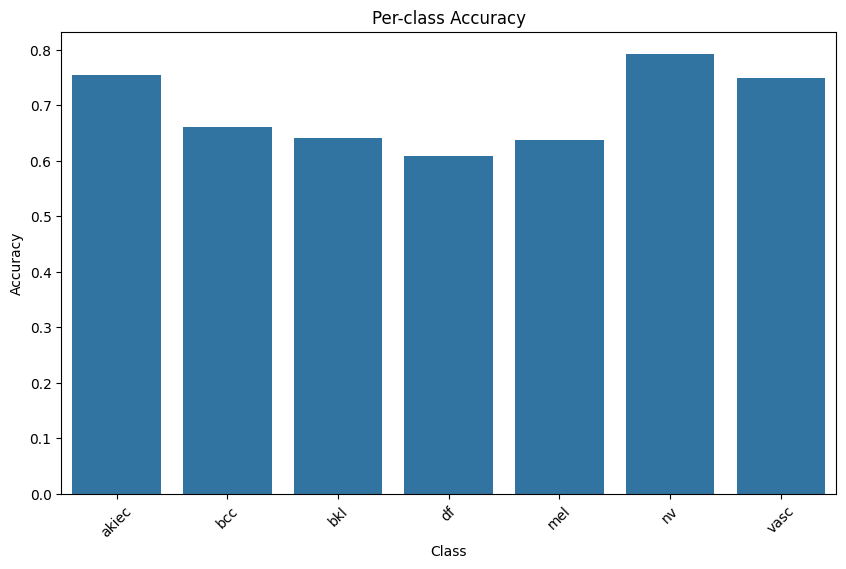

In [21]:
# Per-class Accuracy Plot
class_accuracies = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10, 6))
sns.barplot(x=classes, y=class_accuracies)
plt.title('Per-class Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

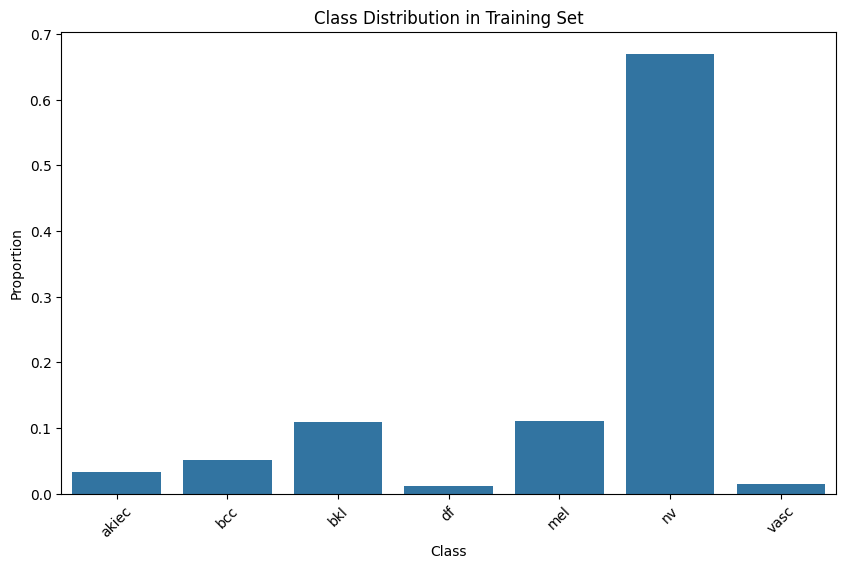

In [22]:
# Class distribution in training set
train_labels = np.concatenate([labels.numpy() for _, labels in train_dataset])
train_class_dist = np.bincount(train_labels) / len(train_labels)

plt.figure(figsize=(10, 6))
sns.barplot(x=classes, y=train_class_dist)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.show()